###Точка входа и работоспособность

In [1]:
import sympy
from sympy.parsing.latex import parse_latex
sympy.init_printing()

**Долгая установка парсера**

К сожалению, чтобы использовать $parse$_$latex$ установки просто $antlr4-python3-runtime$ не достаточно. Чтобы устранить проблемы, нужно устанавливать не последнюю версию данной утилиты, а версию из библиотеки $latex2sympy2$. Потом наконец-то можно пользоваться парсером

In [ ]:
!pip install antlr4-python3-runtime

In [ ]:
!pip install latex2sympy2

$LaTex$ $\rightarrow$ $Sympy$

In [5]:
class Entr:
  x, t, u = sympy.symbols('x t u')
  def __init__(self, s):
    self.s = s
  def entry(self):
    result = []
    with open(self.s, 'r') as file:
      for latex in file:
        result.append(parse_latex(r'{}'.format(latex)))
    return result

Определим переменные через $sympy.symbols$ и проверим работу точки входа 

In [6]:
x, t, u = sympy.symbols('x t u')

In [7]:
test_string = Entr('task_1.txt')

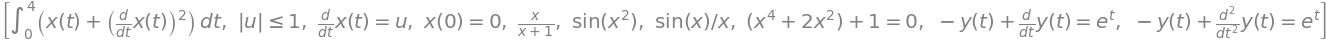

In [8]:
test_string.entry()

Дифференцирование

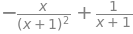

In [9]:
sympy.diff(test_string.entry()[4], x)

Интегрирование

In [10]:
sympy.integrate(test_string.entry()[5], (x, -sympy.oo, sympy.oo))

Поиск предела

In [11]:
sympy.limit(test_string.entry()[6], x, 0)

Решение уравнения

In [12]:
sympy.solve(test_string.entry()[7], x)

Решение дифференциальных уравнений

In [13]:
y = sympy.Function('y')(t)

In [14]:
sympy.dsolve(test_string.entry()[8], y)

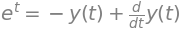

In [16]:
sympy.simplify(test_string.entry()[8])

In [17]:
sympy.dsolve(test_string.entry()[9], y)

###Условия оптимальности

In [ ]:
t= sympy.symbols('t')
p = sympy.Function('p')
x = sympy.Function('x')
u = sympy.Function('u')

Не оптимизированный класс

In [ ]:
class Pontrygin_Method:
  t= sympy.symbols('t')
  p = sympy.Function('p')
  x = sympy.Function('x')
  u = sympy.Function('u')
  @staticmethod
  def f_function(expr): #функции f
    if expr.has(sympy.Integral): #проверяем наличие интеграла в выражении
      if expr.args[0].has(sympy.Integral): #если выражение состоит только из интеграла, то False. Иначе True
        f = expr.args[0].args[0] #берём подытегральное выражение
      else:
        f = expr.args[0] #берём подытегральное выражение
    else:
      f = 0
    return f

  @staticmethod
  def ksi_function(expr): #функции ksi
    if expr.has(sympy.Integral):
      if expr.args[0].has(sympy.Integral): #Если на первом месте стоит интеграл, то значит у нас больше двух коэффициентов, значит второй - наше выражение
        ksi = expr.args[1]
      else:
        ksi = 0 #если False, то значит у нас только интеграл
    else:
      ksi = expr
    return ksi

  def __init__(self, s):
    self.s = s
    self.k = [] #массив значений lambda
    self.x = [] #решение x
    self.u = [] #решение u

  def entry(self): #точка входа
    result = []
    with open(self.s, 'r') as file:
      for latex in file:
        result.append(parse_latex(r'{}'.format(latex)))
    return result

  def k_lambda(self): #массив с lambda
    k = []
    if self.k == []:
      self.k = [[1,0]] * len(self.entry()[:-2])
    for i in range(len(self.entry()[:-2])):
      k.append(sympy.symbols('lambda_{}'.format(i)))
    return k
    

  def L(self): #Лагранжиан
    entry_result = self.entry()
    f = self.k_lambda()[0] * self.f_function(entry_result[0]) #Функционал
    for i, formula in enumerate(entry_result[1:-2], 1): #Ограничения
      f += self.k_lambda()[i] * self.f_function(formula.lhs - formula.rhs)
    return sympy.simplify((p(t) * (x(t).diff(t) - entry_result[-2].rhs) + f.subs(entry_result[-2].lhs, entry_result[-2].rhs)))

  def H(self): #Гамильтониан
    return sympy.simplify(self.L().diff(x(t).diff(t)) * x(t).diff(t) - self.L())

  def l(self): #l-функция
    entry_result = self.entry()
    ksi = self.k_lambda()[0] * self.ksi_function(entry_result[0]) #Функционал
    for i, formula in enumerate(entry_result[1:-2], 1): #Ограничения
      ksi += self.k_lambda()[i] * self.ksi_function(formula.lhs - formula.rhs)
    return sympy.simplify(ksi)

  def dual_system(self): #двойственная система
    return [sympy.Eq(x(t).diff(t), self.H().diff(p(t))), sympy.Eq(p(t).diff(t), - self.H().diff(x(t)))]
  
  def check_lambda(self): #проверка, подходит ли lambda_0 == 0
    if self.dual_system()[1].subs(self.k_lambda()[0], 0).rhs == 0:
      return 1
    else:
      return 0 

  def t(self): #Горизон действия
    entry_result_0 = self.entry()[0] #найдём пределы с помощью интеграла
    if entry_result_0.args[0].has(sympy.Integral): #проверка на то, является ли интеграл единственным в первой строке
      t_0 = entry_result_0.args[0].args[1][1]
      t_1 = entry_result_0.args[0].args[1][2]
    else:
      t_0 = entry_result_0.args[1][1]
      t_1 = entry_result_0.args[1][2]
    return [t_0, t_1]

  def transversalnost(self): #условия трансверсальности
    first_eq = sympy.Eq(p(t).subs(t, self.t()[0]), self.l().diff(x(t).subs(t, self.t()[0]))) #условие с t_0
    second_eq = sympy.Eq(p(t).subs(t, self.t()[1]), -self.l().diff(x(t).subs(t, self.t()[1]))) #условие с t_1
    return [first_eq, second_eq]

  def p_find(self): #поиск p с помощью решения второй двойственной системы
    tr = self.transversalnost()
    lam = self.k_lambda()
    res = sympy.dsolve(self.dual_system()[1], ics={tr[0].lhs : tr[0].rhs}) #решение уравнения с одним условием трансверсальности
    dict_lambda = sympy.solve(res.lhs.subs(p(t), tr[1].rhs) - res.rhs.subs(t, tr[1].lhs.args[0]), dict=True)[0] #получаем словарь из lambda после решения с другим условием трансверсальности
    for key, value in dict_lambda.items():
      result_lambda = sympy.Eq(key, value) #превращаем словарь с lambda в уравнение c lambda
    result_lambda_1 = result_lambda.subs(lam[0], 1) #подставляем lambda_0 = 1
    result_lambda_2 = result_lambda.subs(lam[0], 0) #подставляем lambda_0 = 0
    for key, value in sympy.solve(result_lambda_1.lhs - result_lambda_1.rhs, dict=True)[0].items():
      result_1 = res.subs(lam[0], 1).subs(key, value) #находим p, подставляя lambda
      self.k[1] = [value]
    for key, value in sympy.solve(result_lambda_2.lhs - result_lambda_2.rhs, dict=True)[0].items():
      result_2 = res.subs(lam[0], 0).subs(key, value) #находим p, подставляя lambda
      self.k[1].append(value) 
    if self.check_lambda(): #если lambda_0 == 0
      return [result_1.rhs]
    else:
      return [result_1.rhs, result_2.rhs]

  def u_find(self): #поиск u на основании того, что H-непрерывный
    lam = self.k_lambda()
    p_new = self.p_find()
    H = self.H()
    if self.check_lambda():
      return [(sympy.solve(H.diff(u(t)).subs(lam[0], 1), u(t), list=True)[0]).subs(p(t), p_new[0]).subs(lam[1], self.k[1][0])] #решение уравнения H_u = 0
    else:
      return [(sympy.solve(H.diff(u(t)).subs(lam[0], 1), u(t))[0]).subs(p(t), p_new[0]).subs(lam[1], self.k[1][0]), \
              (sympy.solve(H.diff(u(t)).subs(lam[0], 0), u(t))[0]).subs(p(t), p_new[1]).subs(lam[1], self.k[1][1])]
  
  def x_find(self): #поиск x на с помощью решения первой двойственной системы
    expr = self.dual_system()[0]
    u_new = self.u_find()
    if self.check_lambda():
      return [sympy.dsolve(expr.subs(u(t), u_new[0]), x(t)).rhs]
    else:
      return [sympy.dsolve(expr.subs(u(t), u_new[0]), x(t)).rhs, sympy.dsolve(expr.subs(u(t), u_new[1]), x(t)).rhs]

  def check_integral(self, u_new, x_new, x_new_0, x_new_1, flag=-1): #проверка на наличие интеграла
    sol = []
    t_new = self.t()
    for formula in self.entry()[:-2]:
      if flag == 1:
        temp = formula
        flag = 0
      elif flag == -1:
        flag = 0
        continue
      else:
        temp = (formula.lhs - formula.rhs)
      if temp.has(sympy.Integral):
        if temp.args[0].has(sympy.Integral):
          temp_1 = temp.replace(temp.args[0], sympy.integrate(temp.args[0].args[0].subs([(u(t), u_new), (x(t), x_new)]).doit(),(t,t_new[0], t_new[1])))
          sol.append(sympy.simplify(temp_1.replace(temp.args[1], temp.args[1].subs([(x(t_new[0]), x_new_0), (x(t_new[1]), x_new_1)]).doit())))
        else:
          sol.append(sympy.simplify(temp.replace(temp ,sympy.integrate(temp.args[0].subs([(u(t), u_new), (x(t), x_new)]).doit(), (t, t_new[0], t_new[1])))))
      else:
        sol.append(sympy.simplify(sympy.Eq(temp.subs([(x(t_new[0]), x_new_0), (x(t_new[1]), x_new_1)]).doit(), 0)))
    return sol


  def solution(self): #решает СУ из начальных условий и выводит dict
    t_new = self.t()
    x_new = self.x_find()
    u_new = self.u_find()
    sol_1 = self.check_integral(u_new[0], x_new[0], x_new[0].subs(t, t_new[0]), x_new[0].subs(t, t_new[1]))
    if self.check_lambda():
      return sympy.solve(sol_1, list(sol_1[-1].free_symbols), dict=True)
    else:
      sol_2 = self.check_integral(u_new[1], x_new[1], x_new[1].subs(t, t_new[0]), x_new[1].subs(t, t_new[1]))
      return [sympy.solve(sol_1, list(sol_1[-1].free_symbols), dict=True), \
              sympy.solve(sol_2, list(sol_2[-1].free_symbols), dict=True)]


  def fill_lambda(self, lambda_sol, index):
    self.k[0] = [1,0]
    lam = self.k_lambda()
    for key, value in lambda_sol.items():
      self.x[index] = self.x[index].subs(key, value)
      self.u[index] = self.u[index].subs(key, value)
      for ind, value_lambda in enumerate(lam):
        if value_lambda == key:
          self.k[ind][index] = value
          self.k[1][index] = self.k[1][index].subs(key, value)

  def KKT(self):
    self.x = self.x_find()
    self.u = self.u_find()
    t_new = self.t()
    self.fill_lambda(self.solution()[0], 0)
    functional_1 = self.check_integral(self.u[0], self.x[0], self.x[0].subs(t, t_new[0]), self.x[0].subs(t, t_new[1]), 1)
    if self.check_lambda():
      return [(functional_1[index], self.k[index][0]) for index in range(len(functional_1))]
    else:
      self.fill_lambda(self.solution()[1], 1)
      functional_2 = self.check_integral(self.u[1], self.x[1], self.x[1].subs(t, t_new[0]), self.x[1].subs(t, t_new[1]), 1)
      return [[(functional_1[index], self.k[index][0]) for index in range(len(functional_1))], [(functional_2[index], self.k[index][1]) for index in range(len(functional_2))]]
      
  def start(self):
    return self.entry(), \
           self.L(), \
           self.l(), \
           self.H(), \
           self.dual_system(), \
           self.transversalnost(), \
           self.p_find(), \
           self.x_find(), \
           self.u_find(), \
           self.solution(), \
           self.KKT()

In [ ]:
test = Pontrygin_Method('task_4.txt')

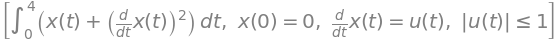

In [ ]:
test.entry()

In [ ]:
test.H()

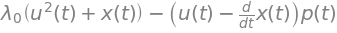

In [ ]:
test.L()

In [ ]:
test.l()

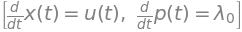

In [ ]:
test.dual_system()

In [ ]:
test.x_find()

In [ ]:
test.u_find()

In [ ]:
test.p_find()

In [ ]:
test.solution()

In [ ]:
test.KKT()

[(-16/3, 1), (True, -4)]

In [ ]:
t= sympy.symbols('t')
p = sympy.Function('p')
x = sympy.Function('x')
u = sympy.Function('u')

Оптимизированный класс

In [ ]:
from sympy.solvers.inequalities import reduce_rational_inequalities
from sympy.solvers import inequalities
class Pontrygin_Method_test:
  t= sympy.symbols('t')
  p = sympy.Function('p')
  x = sympy.Function('x')
  u = sympy.Function('u')
  @staticmethod
  def f_function(expr): #функции f
    if expr.has(sympy.Integral): #проверяем наличие интеграла в выражении
      if expr.args[0].has(sympy.Integral): #если выражение состоит только из интеграла, то False. Иначе True
        f = expr.args[0].args[0] #берём подытегральное выражение
      else:
        f = expr.args[0] #берём подытегральное выражение
    else:
      f = 0
    return f

  @staticmethod
  def ksi_function(expr): #функции ksi
    if expr.has(sympy.Integral):
      if expr.args[0].has(sympy.Integral): #Если на первом месте стоит интеграл, то значит у нас больше двух коэффициентов, значит второй - наше выражение
        ksi = expr.args[1]
      else:
        ksi = 0 #если False, то значит у нас только интеграл
    else:
      ksi = expr
    return ksi

  @staticmethod
  def _check_integral(u_new, x_new, x_new_0, x_new_1, t_new, temp):
    if temp.has(sympy.Integral):
      if temp.args[0].has(sympy.Integral):
        temp_1 = temp.replace(temp.args[0], sympy.integrate(temp.args[0].args[0].subs([(u(t), u_new), (x(t), x_new)]).doit(),(t,t_new[0], t_new[1])))
        sol = sympy.simplify(temp_1.replace(temp.args[1], temp.args[1].subs([(x(t_new[0]), x_new_0), (x(t_new[1]), x_new_1)]).doit()))
      else:
        sol = sympy.simplify(temp.replace(temp ,sympy.integrate(temp.args[0].subs([(u(t), u_new), (x(t), x_new)]).doit(), (t, t_new[0], t_new[1]))))
    else:
      sol = sympy.simplify(temp.subs([(x(t_new[0]), x_new_0), (x(t_new[1]), x_new_1)]).doit())
    return sol

  @staticmethod
  def _check_conditions(conditions, k):
    eq = []
    ineq = conditions[1]
    for i in range(len(conditions[0])):
      eq.append(sympy.Eq(k[i + 1] * conditions[0][i], 0)) # lambda_i * functional_i
    for j in range(1, 1 + len(conditions[0]) + len(conditions[1])):
      ineq.append(k[j])
    return (eq, ineq)

  @staticmethod
  def _result_solution(x, u, p, condition, k, res):
    for key, value in res.items():
      x = x.subs(key, value)
      u = u.subs(key, value)
      p = p.subs(key, value)
      for ind in range(1, len(k)):
        k[ind] = k[ind].subs(key, value)
      for ind in range(len(condition)):
        condition[ind] = condition[ind].subs(key, value)
    return x, u, p, k, condition


  def decorator_initial(func):
    def wrapper(self, s):
      func(self, s)
      setattr(Pontrygin_Method_test, 'entry', self._entry())
      setattr(Pontrygin_Method_test, 'k_0', self._get_lambda_function())
      setattr(Pontrygin_Method_test, 'k_1', self._get_lambda_function())
      setattr(Pontrygin_Method_test, 'k', self._get_lambda_function())
      setattr(Pontrygin_Method_test, 't', self._t())
      setattr(Pontrygin_Method_test, 'm', self._get_m_function())
    return wrapper

  @decorator_initial
  def __init__(self, s):
    self.s = s
    self.x = [] #решение x
    self.u = [] #решение u

  def _entry(self): #точка входа
    result = []
    with open(self.s, 'r') as file:
      for latex in file:
        result.append(parse_latex(r'{}'.format(latex)))
    return result

  def _get_m_function(self):
    m = 1
    for formula in self.entry[1:-2]:
      if formula.rel_op == '<=':
        break
      m += 1
    return m

  def _get_lambda_function(self):
    k = []
    for i in range(len(self.entry[:-2])):
      k.append(sympy.symbols('lambda_{}'.format(i)))
    return k
  
  def _t(self): #Горизон действия
    entry_result_0 = self.entry[0] #найдём пределы с помощью интеграла
    if entry_result_0.args[0].has(sympy.Integral): #проверка на то, является ли интеграл единственным в первой строке
      t_0 = entry_result_0.args[0].args[1][1]
      t_1 = entry_result_0.args[0].args[1][2]
    else:
      t_0 = entry_result_0.args[1][1]
      t_1 = entry_result_0.args[1][2]
    return [t_0, t_1]

  def L(self): #Лагранжиан
    f = self.k[0] * self.f_function(self.entry[0]) #Функционал
    for i, formula in enumerate(self.entry[1:-2], 1): #Ограничения
      f += self.k[i] * self.f_function(formula.lhs - formula.rhs)
    return sympy.simplify((p(t) * (x(t).diff(t) - self.entry[-2].rhs) + f.subs(self.entry[-2].lhs, self.entry[-2].rhs)))

  def H(self): #Гамильтониан
    return sympy.simplify(self.L().diff(x(t).diff(t)) * x(t).diff(t) - self.L())

  def l(self): #l-функция
    ksi = self.k[0] * self.ksi_function(self.entry[0]) #Функционал
    for i, formula in enumerate(self.entry[1:-2], 1): #Ограничения
      ksi += self.k[i] * self.ksi_function(formula.lhs - formula.rhs)
    return sympy.simplify(ksi)

  def dual_system(self): #двойственная система
    return [sympy.Eq(x(t).diff(t), self.H().diff(p(t))), sympy.Eq(p(t).diff(t), - self.H().diff(x(t)))]
  
  def check_lambda(self): #проверка, подходит ли lambda_0 == 0
    if self.dual_system()[1].subs(self.k[0], 0).rhs == 0:
      return 0
    else:
      return 1

  def transversalnost(self): #условия трансверсальности
    first_eq = sympy.Eq(p(t).subs(t, self.t[0]), self.l().diff(x(t).subs(t, self.t[0]))) #условие с t_0
    second_eq = sympy.Eq(p(t).subs(t, self.t[1]), -self.l().diff(x(t).subs(t, self.t[1]))) #условие с t_1
    return [first_eq, second_eq]

  def decorator_solve(func):
    def wrapper(self):
      func(self)
      self._u_find()
      self._x_find()
    return wrapper

  @decorator_solve
  def find_all(self): #поиск p с помощью решения второй двойственной системы
    tr = self.transversalnost()
    res = sympy.dsolve(self.dual_system()[1], ics={tr[0].lhs : tr[0].rhs}) #решение уравнения с одним условием трансверсальности
    dict_lambda = sympy.solve(res.lhs.subs(p(t), tr[1].rhs) - res.rhs.subs(t, tr[1].lhs.args[0]), dict=True)[0] #получаем словарь из lambda после решения с другим условием трансверсальности
    for key, value in dict_lambda.items():
      result_lambda = sympy.Eq(key, value) #превращаем словарь с lambda в уравнение c lambda
    result_lambda_1 = result_lambda.subs(self.k[0], 1) #подставляем lambda_0 = 1
    result_lambda_0 = result_lambda.subs(self.k[0], 0) #подставляем lambda_0 = 0
    self.k_0[0], self.k_1[0] = 0, 1 
    for key, value in sympy.solve(result_lambda_1.lhs - result_lambda_1.rhs, dict=True)[0].items():
      result_1 = res.subs(self.k[0], 1).subs(key, value) #находим p, подставляя lambda
      self.k_1[1] = value
    for key, value in sympy.solve(result_lambda_0.lhs - result_lambda_0.rhs, dict=True)[0].items():
      result_0 = res.subs(self.k[0], 0).subs(key, value) #находим p, подставляя lambda
      self.k_0[1] = value
    setattr(Pontrygin_Method_test, 'p_1', result_1.rhs)
    if self.check_lambda(): #если lambda_0 == 0
      setattr(Pontrygin_Method_test, 'p_0', result_0.rhs)

  def _u_find(self): #поиск u на основании того, что H-непрерывный
    H = self.H()
    setattr(Pontrygin_Method_test, 'u_1', (sympy.solve(H.diff(u(t)).subs(self.k[0], 1), u(t), list=True)[0]).subs(p(t), self.p_1).subs(self.k[1], self.k_1[1]))
    if self.check_lambda():
      setattr(Pontrygin_Method_test, 'u_0', (sympy.solve(H.diff(u(t)).subs(self.k[0], 0), u(t), list=True)[0]).subs(p(t), self.p_0).subs(self.k[1], self.k_0[1]))

  def _x_find(self): #поиск x на с помощью решения первой двойственной системы
    expr = self.dual_system()[0]
    setattr(Pontrygin_Method_test, 'x_1', sympy.dsolve(expr.subs(u(t), self.u_1), x(t)).rhs)
    if self.check_lambda():
      setattr(Pontrygin_Method_test, 'x_0', sympy.dsolve(expr.subs(u(t), self.u_0), x(t)).rhs)

  def _eq_and_ineq(self, u_new, x_new, x_new_0, x_new_1, t_new): #разбение на уравнения и неравенства для ККТ
    sol = []
    ineq = []
    for formula in self.entry[1:-2]:
      if (formula.rel_op == '<='):
        ineq.append(self._check_integral(u_new, x_new, x_new_0, x_new_1, t_new, formula.lhs - formula.rhs))
      else:
        sol.append(self._check_integral(u_new, x_new, x_new_0, x_new_1, t_new, formula.lhs - formula.rhs))
    return (sol, ineq)


  def _new_conditions(self):
    sol_1 = self._eq_and_ineq(self.u_1, self.x_1, self.x_1.subs(t, self.t[0]), self.x_1.subs(t, self.t[1]), self.t)
    setattr(Pontrygin_Method_test, 'conditions_1', [sol_1[0], sol_1[1]])
    if self.check_lambda():
      sol_0 = self._eq_and_ineq(self.u_0, self.x_0, self.x_0.subs(t, self.t[0]), self.x_0.subs(t, self.t[1]), self.t)
      setattr(Pontrygin_Method_test, 'conditions_0', [sol_0[0], sol_0[1]]) 


  def new_KKT(self):
    self.find_all()
    self._new_conditions()
    kkt_cond_1 = self._check_conditions(self.conditions_1, self.k_1)
    setattr(Pontrygin_Method_test, 'kkt_1', kkt_cond_1)
    if self.check_lambda():
      kkt_cond_0 = self._check_conditions(self.conditions_0, self.k_0)
      setattr(Pontrygin_Method_test, 'kkt_0', kkt_cond_0)
      return [kkt_cond_1, kkt_cond_0]
    else:
      return [kkt_cond_1]

  def new_eq_solution(self):
    eq_1 = self.new_KKT()[0][0]
    return sympy.solve(eq_1, list(eq_1[-1].free_symbols), dict=True)
    if self.check_lambda():
      eq_0 = self.new_KKT()[1][0]
      return [sympy.solve(eq_1, list(eq_1[-1].free_symbols), dict=True),\
              sympy.solve(eq_0, list(eq_0[-1].free_symbols), dict=True)]

  def check_solution_with_ineq(self):
    d_list = self.new_eq_solution()
    ineq = self.new_KKT()[0][1]
    for d in d_list:
      # symbol = []
      k = 0
      for formula in ineq:
        temp = formula
        for key, value in d.items():
          temp = temp.subs(key, value)
        # symbol = list(set(symbol))
        # symbol.extend(list(temp.free_symbols))
        if temp <= 0:
            k += 1
      if k == len(ineq):
        return d


  def result(self):
    res = self.check_solution_with_ineq()
    return self._result_solution(self.x_1, self.u_1, self.p_1, self.kkt_1[0], self.k_1, res)

In [ ]:
test = Pontrygin_Method_test('task_3.txt')

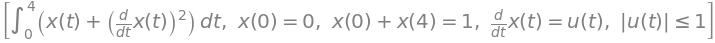

In [ ]:
test.entry

In [ ]:
test.L()

In [ ]:
test.H()

In [ ]:
test.l()

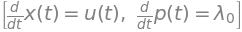

In [ ]:
test.dual_system()

In [ ]:
test.transversalnost()

In [ ]:
test.new_KKT()

In [ ]:
test.x_1

In [ ]:
test.u_1

In [ ]:
test.p_1

In [ ]:
test.new_eq_solution()

In [ ]:
test.check_solution_with_ineq()

x, u, p, k, condition

In [ ]:
test.result()

⎛ 2                                              ⎞
⎜t         t                                     ⎟
⎜── - 2⋅t, ─ - 2, t - 4, [1, -4, 0], [True, True]⎟
⎝4         2                                     ⎠